In [1]:
#라이브러리 및 모듈 불러오기
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import models, layers
from tensorflow.keras.layers import BatchNormalization
import os
import PIL
from PIL import Image
import tensorflow_datasets as tfds

In [2]:
# GPU환경설정 확인
tf.compat.v1.disable_eager_execution()

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to true
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 1s 0us/step


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [5]:
# 꽃들의 종류별 사진 불러오기
roses = list(data_dir.glob('roses/*'))
daisy = list(data_dir.glob('daisy/*'))
dandelion = list(data_dir.glob('dandelion/*'))
sunflowers = list(data_dir.glob('sunflowers/*'))
tulips = list(data_dir.glob('tulips/*'))

In [6]:
# 꽃 종류별 갯수
dir_list = [roses, daisy, dandelion, sunflowers, tulips]
num_flower_bytype = {'num_roses':'', 'num_daisy':'', 'num_dandelion':'', 'num_tulips':''}

def count_flowers(flower_list):
    flower_types = ['num_roses', 'num_daisy', 'num_dandelion', 'num_sunflowers', 'num_tulips']
    for i, flower_type in enumerate(flower_types):
        num_flower_bytype[flower_type] = len(flower_list[i])
    return num_flower_bytype

show_count = count_flowers(dir_list)
print(num_flower_bytype)


{'num_roses': 641, 'num_daisy': 633, 'num_dandelion': 898, 'num_tulips': 799, 'num_sunflowers': 699}


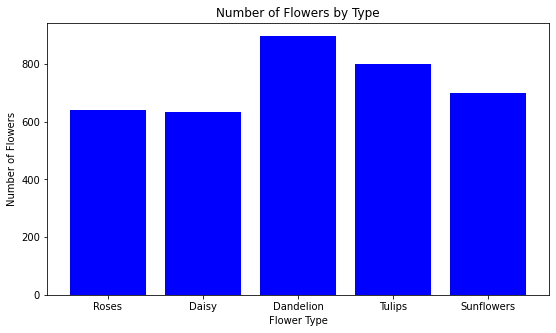

In [7]:
# 꽃의 종류마다 수를 시각화
flower_type = ['Roses', 'Daisy', 'Dandelion', 'Tulips', 'Sunflowers']
plt.figure(figsize=(9,5))
plt.bar(flower_type, num_flower_bytype.values(), color='blue')
plt.xlabel('Flower Type')
plt.ylabel('Number of Flowers')
plt.title('Number of Flowers by Type')
plt.show()

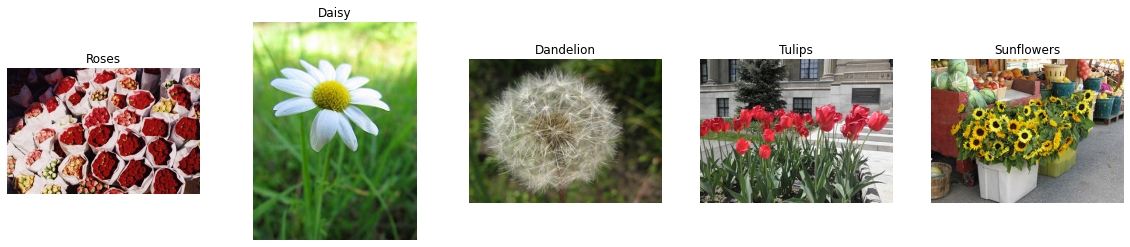

In [8]:
# 꽃의 종류마다 시각화.
image_list = [roses[0], daisy[0], dandelion[0], tulips[0], sunflowers[0]]

loaded_images = [Image.open(path) for path in image_list]

plt.figure(figsize=(20, 4))

for i, img in enumerate(loaded_images):
    plt.subplot(1, 5, i + 1) 
    plt.imshow(img)
    plt.title(flower_type[i])
    plt.axis('off')

plt.show()

In [9]:
# 이미지리사이징 및 정규화
def process_image(image_path):
    img = Image.open(image_path)
    img = img.resize((180, 180))
    img_array = np.array(img) / 255.0 
    
    return img_array

# 종류별로 경로따라서 리사이징 및 정규화
processed_roses = [process_image(path) for path in roses]
processed_daisy = [process_image(path) for path in daisy]
processed_dandelion = [process_image(path) for path in dandelion]
processed_sunflowers = [process_image(path) for path in sunflowers]
processed_tulips = [process_image(path) for path in tulips]

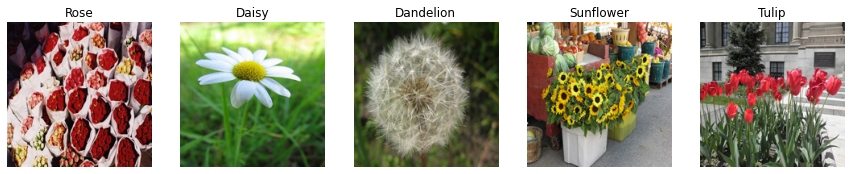

In [10]:
# 정규화된 이미지 시각화
plt.figure(figsize=(15, 3))
labels = ['Rose', 'Daisy', 'Dandelion', 'Sunflower', 'Tulip']
for i, img_list in enumerate([processed_roses, processed_daisy, processed_dandelion, processed_sunflowers, processed_tulips]):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img_list[0])  # Displaying the first image of each category
    plt.title(labels[i])
    plt.axis('off')
plt.show()

In [13]:
# Data Augmentation

import random
from PIL import Image, ImageEnhance

def aug_images(img_list, aug_type, num_aug_img):
    augmented_images = []

    for _ in range(num_aug_img):
        # 이미지 리스트에서 랜덤하게 선택
        img_array = random.choice(img_list)
        img = Image.fromarray(np.uint8(img_array * 255))
        
        if aug_type == "saturation":
            enhancer = ImageEnhance.Color(img)
            img_aug = enhancer.enhance(random.uniform(0.5, 1.5))  # 랜덤하게 saturation을 변화

        elif aug_type == "brightness":
            enhancer = ImageEnhance.Brightness(img)
            img_aug = enhancer.enhance(random.uniform(0.5, 1.5))  # 랜덤하게 밝기 조정

        augmented_images.append(img_aug)

    return augmented_images

In [14]:
# 꽃의 종류별 saturation, brightness로 Augmentation
# Augmentation 당 600 장 씩
roses_saturation = aug_images(processed_roses, "saturation", 600)
roses_brightness = aug_images(processed_roses, "brightness", 600)

daisy_saturation = aug_images(processed_daisy, "saturation", 600)
daisy_brightness = aug_images(processed_daisy, "brightness", 600)

dandelion_saturation = aug_images(processed_dandelion, "saturation", 600)
dandelion_brightness = aug_images(processed_dandelion, "brightness", 600)

sunflowers_saturation = aug_images(processed_sunflowers, "saturation", 600)
sunflowers_brightness = aug_images(processed_sunflowers, "brightness", 600)

tulips_saturation = aug_images(processed_tulips, "saturation", 600)
tulips_brightness = aug_images(processed_tulips, "brightness", 600)

In [15]:
# Augmentation 시각화 함수 정의
def plot_augmented_images(original_images, augmented_images, title, num_examples=5):
    plt.figure(figsize=(10, 4))

    for i in range(num_examples):
        # 원본 먼저 그리기
        plt.subplot(2, num_examples, i + 1)
        plt.imshow(original_images[i])
        plt.title("Original")
        plt.axis('off')

        # augment 된 이미지 그리기
        plt.subplot(2, num_examples, num_examples + i + 1)
        plt.imshow(augmented_images[i])
        plt.title(title)
        plt.axis('off')

    plt.suptitle(f'{title} Augmentation Examples')
    plt.show()

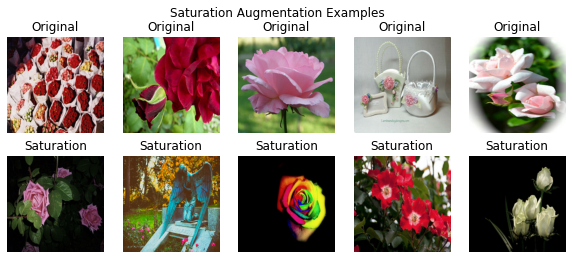

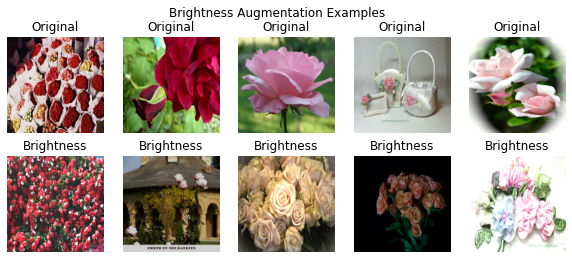

In [16]:
# 장미원본 5장, Augment각 5장
example_roses = processed_roses[:5]
example_roses_saturation = roses_saturation[:5]
example_roses_brightness = roses_brightness[:5]

# Saturation 시각화
plot_augmented_images(example_roses, example_roses_saturation, "Saturation")

# 밝기조정 시각화
plot_augmented_images(example_roses, example_roses_brightness, "Brightness")

In [17]:
#원본 이미지, Augmented 이미지 합치기
train_roses = processed_roses + roses_saturation + roses_brightness
train_daisy = processed_daisy + daisy_saturation + daisy_brightness
train_dandelion = processed_dandelion + dandelion_saturation + dandelion_brightness
train_sunflower = processed_sunflowers + sunflowers_saturation + sunflowers_brightness
train_tulip = processed_tulips + tulips_saturation + tulips_brightness

In [18]:
#카테고리별 레이블 딕셔너리에 저장
flower_labels = {'roses': 0, 'daisy': 1, 'dandelion': 2, 'sunflowers': 3, 'tulips': 4}

#모든테스트 이미지와 레이블을 저장하기 위해 리스트 initialize
combined_dataset = []
combined_label = []

#모든 꽃들을 합치는 함수
def add_to_dataset(flower_type, images, label):
    combined_dataset.extend(images)
    combined_label.extend([label] * len(images))

#데이터셋 합치기
add_to_dataset('roses', train_roses, flower_labels['roses'])
add_to_dataset('daisy', train_daisy, flower_labels['daisy'])
add_to_dataset('dandelion', train_dandelion, flower_labels['dandelion'])
add_to_dataset('sunflower', train_sunflower, flower_labels['sunflowers'])
add_to_dataset('tulips', train_tulip, flower_labels['tulips'])

In [19]:
x_train = np.array(combined_dataset)
y_train = np.array(combined_label)

x_train_shape = x_train.shape
y_train_shape = y_train.shape

print(f'shape of x_train: {x_train_shape}')
print(f'shape of y_train: {y_train_shape}')

/tmp/ipykernel_47/630624131.py:1: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  x_train = np.array(combined_dataset)


shape of x_train: (9670,)
shape of y_train: (9670,)


/tmp/ipykernel_47/630624131.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array(combined_dataset)


In [20]:
%matplotlib inline

In [21]:
#이미지 불러온 후 리사이즈 부터 정규화하는 함수

def img_normalize(path, height, width):
    image_files = os.listdir(path) # 파일 경로에 있는 폴더안에 모든 파일을 리스트 형태로 저장
    images = []
    # 폴더안에 있는 모든 파일을 하나씩 for 문으로 보기
    for file in image_files:
        img_path = os.path.join(path, file)  # 파일의 전체 경로를 구함
        img = Image.open(img_path)
        rgb_img = img.convert('RGB') # RGB 로 변환
        images.append(rgb_img) # images 리스트에 RGB 로 변환된 이미지를 추가

    # 리사이징
    resized_images = [img.resize((width, height)) for img in images]

    # 이미지 정규화 
    normalized_images = [np.array(img) / 255.0 for img in resized_images]
    return normalized_images

In [23]:
#파일 경로
img_path_tulip = r"C:\Users\김대선\Downloads\archive (4)\flowers\tulip"
img_path_sunflower = r"C:\Users\김대선\Downloads\archive (4)\flowers\sunflower"
img_path_rose = r"C:\Users\김대선\Downloads\archive (4)\flowers\rose"
img_path_dandelion = r"C:\Users\김대선\Downloads\archive (4)\flowers\dandelion"
img_path_daisy = r"C:\Users\김대선\Downloads\archive (4)\flowers\daisy"

#파라미터 가로 세로 설정, 리사이징 및 정규화 함수 call
h, w = (180, 180)
img_normalized_tulip = img_normalize(img_path_tulip, h, w)
img_normalized_sunflower = img_normalize(img_path_sunflower, h, w)
img_normalized_rose = img_normalize(img_path_rose, h, w)
img_normalized_dandelion = img_normalize(img_path_dandelion, h, w)
img_normalized_daisy = img_normalize(img_path_daisy, h, w)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\김대선\\Downloads\\archive (4)\\flowers\\tulip'

In [25]:
#TEST 데이터 shape 찍어보기
img_arr_test = np.array(img_normalized_rose)

print(f"shape of test images: {img_arr_test.shape}")

NameError: name 'img_normalized_rose' is not defined

In [26]:
#이미지 그려보기
plt.imshow(img_normalized_rose[1])
plt.show

NameError: name 'img_normalized_rose' is not defined

In [27]:
#카테고리별 레이블을 딕셔너리에 저장
flower_test_labels = {'roses': 0, 'daisy': 1, 'dandelion': 2, 'sunflowers': 3, 'tulips': 4}

#모든 테스트 이미지와 레이블을 저장하기 위해 리스트 initialize
combined_testset = []
combined_test_label = []

#리스트 합치는 함수
def add_to_dataset(flower_type, images, label):
    combined_testset.extend(images)
    combined_test_label.extend([label] * len(images))

#합치기 시작!
add_to_dataset('roses', img_normalized_rose, flower_test_labels['roses'])
add_to_dataset('daisy', img_normalized_daisy, flower_test_labels['daisy'])
add_to_dataset('dandelion', img_normalized_dandelion, flower_test_labels['dandelion'])
add_to_dataset('sunflower', img_normalized_sunflower, flower_test_labels['sunflowers'])
add_to_dataset('tulips', img_normalized_tulip, flower_test_labels['tulips'])

NameError: name 'img_normalized_rose' is not defined

In [28]:
#테스트 데이터 shape 찍어보기
x_test = np.array(combined_testset)
y_test = np.array(combined_test_label)

x_test_shape = x_test.shape
y_test_shape = y_test.shape

print(f'shape of x_test: {x_test_shape}')
print(f'shape of y_test: {y_test_shape}')

shape of x_test: (0,)
shape of y_test: (0,)


In [29]:
from sklearn.model_selection import train_test_split

#훈련데이터 검증데이터 분리
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [30]:
print(f'shape of train: {x_train.shape}')
print(f'shape of validation train: {x_val.shape}')
print(f'shape of train label: {y_train.shape}')
print(f'shape of validation label: {y_val.shape}')

shape of train: (7736,)
shape of validation train: (1934,)
shape of train label: (7736,)
shape of validation label: (1934,)


In [34]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, regularizers

#VGG 모델 Affine 제외하고 불러오기
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

# Affine 계층만 학습하기 위해 convolution 계층은 freeze
base_model.trainable = False

#convolution 위에 레이어 쌓기
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dense(5), 
    layers.BatchNormalization(),
    layers.Activation('softmax')])

#모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               3277056   
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
_________________________________________________________________
batch_normalization_3 (Batch (None, 5)                

In [35]:
from tensorflow.keras.callbacks import EarlyStopping
#early stop 세팅
early_stopper = EarlyStopping(
    monitor='val_loss',     # Metric to be monitored 
    patience=4,            # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='auto',            # Decides whether the monitored quantity is supposed to increase or decrease
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

#모델 학습
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=5,
    callbacks=[early_stopper]
)

ValueError: Error when checking input: expected vgg16_input to have 4 dimensions, but got array with shape (7736, 1)

In [ ]:
#훈련데이터 검증데이터 loss, Accuracy 시각화
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss)+1)
fig = plt.figure(figsize = (12,5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [36]:
#Test
model.evaluate(x_test, y_test)

ValueError: Error when checking input: expected vgg16_input to have 4 dimensions, but got array with shape (0, 1)

In [ ]:
#모델 저장
model.save(r"C:\Users\김대선\Aiffel\AIFFEL_Quest\DL_lms\exploration1")